In [7]:
%load_ext autoreload
%autoreload 2

# Four in a row Agent and Environment

This is an implementation of a rational agents for the game four in a row.

## 1. Definition of the Environment

- States: The environment is in one of the following states $S = (S_0, S_1, ..., S_w)$ with $S_x = (S_{x,0}, S_{x,1}, ..., S_{x,h})$ and $S_{x,y} \in \{E, R, Y\}$.
- Actions: The set of  available actions: $a \in \{n \in \mathbb{N}: (|E \in S_n| > 0)\}$ (the agent can place their chip in any non-full column).
- Transitions: The transition depends on the opponent's strategy. If we assume the opponent plays randomly then the probability of them picking a viable column is $\dfrac{1}{nr\;of\;valid\;columns}$

The `FourInARowEnv` class has the following methods:
- `reset()` resets the environment's state to it's initial state.
- `step(action)` processes the action of the agent.
- `render()` displays the state using box characters.
- `get_state()` returns the current state.
- `is_done()` checks if there is a winner of if the board is full.

To allow an agent to calculate optimal decisions using model information, these methods are also available:
- `get_possible_states()` calculates all possible future states.
- `get_reward_for_state(state)` simplified version $R(s)$ of the general reward function: $R(s, a, s')$.
- `get_transition_prob(action, new_state, old_state)` $P(s' \mid s, a)$.
- `get_possible_actions(action)` returns the possible actions.
- `get_possible_states_after_action(action)` calculates the possible states after an action.


### 1.1 Definition of an agent

Agents have access to the environment they play in and what player they play as. 

An agent has the following method:
- `get_move()` which returns the column the agent will play.
- `get_transition_probability(possible_states, new_state)` which gives the probability of the `new_state` being chosen from the `possible_states`. This method is only relevant if the agent is part of the environment.

The agents we implemented:
- A random agent
- A semi-random agent
- A brute force agent (does not have `get_transition_probability`)
- A Value Iteration agent (does not have `get_transition_probability`)

## 2. Environment Creation

We are able to create an environment with several parameters:

- `yellow_agent` is used to define an agent that will act as the opponent.
- `width` the width of the playing field.
- `height` the height of the playing field.
- `win_conditions` the number of chips in a row required to win.
- `first_turn` the player that will play first.


In [1]:
from src import FourInARowEnv, Players, render_multiple_states, BoxState, FourInARowRenderer,FourInARowGraphCreator
from src.agents import FourInARowRandomAgent, FourInARowBruteForceAgent, FourInARowValueIterationAgent, FourInARowSemiRandomAgent
from copy import deepcopy

In [2]:
environment = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

### 2.1 Displaying the board

The board is displayed using box characters. The letter `Y` represents a yellow chip, and the letter `R` represents a red one.

In [10]:
red_agent = FourInARowRandomAgent(environment)

environment.step(red_agent.get_move())

print(environment.render())

┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│   │ R │ Y │
└───┴───┴───┘


## 3. Actions and probability

### 3.1 Possible states and actions

Below is a showcase of calculating the first 16 possible states. Additionally it includes the available actions for each state and wether or not the state is "finished".

In [11]:
environment.reset()

display = render_multiple_states(
  states          = environment.get_possible_states()[0:16], 
  columns         = 8, 
  additional_info = lambda s: f'a: {environment.get_possible_actions(s)}\nf: {s.is_finished()}'
)

print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │ R │   │   │ │ R │   │   │ │ R │   │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │   │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │ R │   │ │ Y │ R │   │ │ Y │ R │   │ │ Y │ R │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│ R │   │   │ │ R │   │   │ │ R │   │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │ Y │ R │ │ R │ Y │ Y │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
 a: [0, 1, 2]  a: [0, 1, 2]  a: [1, 2]     a: [1, 2]     a: [1, 2]     a: [2]        a: []         a: [1, 2]   
 f: False      f: False      f: False      f: False      f: False      f: False      f: True       f: Fa

### 3.2 Transition probability

As the name suggests, the transition probability is the probability the game ends up in a new state, after preforming an action.
For this we make use of the `.get_transition_prob` method. As mentioned previously this methods takes:  
- A new action (column number),
- the old state.
- a new state.

The method return a value of 0 if:
- The column of the new action is full.
- The game of the old state is finished.
- The game is finished after preforming an action and the this state doesn't equals the given state (The other agent won't make a turn after the game finished)


The method return always a value of 1 if:
- The game is finished after preforming an action and the this state equals the given state (The other agent won't make a turn after the game finished)

In all other cases the transition probability will be calculated as follows:
1. Calculate all posible new states from the state after a users actions (all moves the opponent can make, after the user has placed the chip in the given column).
2. If the given new state is not in this list return 0 (No action of the opponent would result in this state after the user has made a move).
3. If the new state is in this list return 1/(number of possible states)


In [12]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 2,
  height        = 2,
  win_condition = 2,
  first_turn    = Players.RED
)
s0 = deepcopy(env._state)
s1 = deepcopy(s0)
s1._grid = [
  [BoxState.RED   , BoxState.YELLOW],
  [BoxState.EMPTY , BoxState.EMPTY ]
]
s2 = deepcopy(s0)
s2._grid = [
  [BoxState.RED   , BoxState.EMPTY],
  [BoxState.YELLOW, BoxState.EMPTY]
]
s3 = deepcopy(s0)
s3._grid = [
  [BoxState.RED    , BoxState.YELLOW],
  [BoxState.EMPTY  , BoxState.EMPTY ]
]
s4 = deepcopy(s0)
s4._grid = [
  [BoxState.RED    , BoxState.EMPTY ],
  [BoxState.EMPTY  , BoxState.YELLOW]
]

print('Start state:')
print(FourInARowRenderer(s0).render())

display = render_multiple_states(
  states          = [s1, s2, s3, s4],
  columns         = 8,
  additional_info = lambda s: f'Action 0\np: {round(env.get_transition_prob(action=0, new_state=s, old_state=s0), 2)}'
)

print('\nNew state:')
print(display)


Start state:
┌───┬───┐
│   │   │
├───┼───┤
│   │   │
└───┴───┘

New state:
┌───┬───┐ ┌───┬───┐ ┌───┬───┐ ┌───┬───┐
│ Y │   │ │   │   │ │ Y │   │ │   │ Y │
├───┼───┤ ├───┼───┤ ├───┼───┤ ├───┼───┤
│ R │   │ │ R │ Y │ │ R │   │ │ R │   │
└───┴───┘ └───┴───┘ └───┴───┘ └───┴───┘
 Action 0  Action 0  Action 0  Action 0
 p: 0.5    p: 0.5    p: 0.5    p: 0.0  




In [13]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 2,
  height        = 2,
  win_condition = 2,
  first_turn    = Players.RED
)
s0 = deepcopy(env._state)
s0._grid = [
  [BoxState.RED   , BoxState.EMPTY ],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s1 = deepcopy(s0)
s1._grid = [
  [BoxState.RED   , BoxState.RED],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s2 = deepcopy(s0)
s2._grid = [
  [BoxState.RED   , BoxState.RED   ],
  [BoxState.YELLOW, BoxState.YELLOW]
]

print('Start state:')
print(FourInARowRenderer(s0).render())

display = render_multiple_states(
  states          = [s1, s2],
  columns         = 8,
  additional_info = lambda s: f'Action 0\np: {round(env.get_transition_prob(0, s, s0), 2)}'
)

print('\nNew state:')
print(display)


Start state:
┌───┬───┐
│   │   │
├───┼───┤
│ R │ Y │
└───┴───┘

New state:
┌───┬───┐ ┌───┬───┐
│ R │   │ │ R │ Y │
├───┼───┤ ├───┼───┤
│ R │ Y │ │ R │ Y │
└───┴───┘ └───┴───┘
 Action 0  Action 0
 p: 1.0    p: 0.0  




### 3.3 Rewards

The reward model is very basic. If the player wins the reward will result in 1 and if the opponent wins it results in a -1. For neutral states it will return 0.


In [14]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 2,
  height        = 2,
  win_condition = 2,
  first_turn    = Players.RED
)
s0 = deepcopy(env._state)
s0._grid = [
  [BoxState.RED   , BoxState.EMPTY ],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s1 = deepcopy(s0)
s1._grid = [
  [BoxState.RED   , BoxState.RED],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s2 = deepcopy(s0)
s2._grid = [
  [BoxState.RED   , BoxState.EMPTY  ],
  [BoxState.YELLOW, BoxState.YELLOW ]
]

display = render_multiple_states(
  states          = [s0, s1, s2],
  columns         = 8,
  additional_info = lambda s: f'r: {env.get_reward_for_state(s, Players.RED)}'
)
print('Rewards for player red:')
print(display)

Rewards for player red:
┌───┬───┐ ┌───┬───┐ ┌───┬───┐
│   │   │ │ R │   │ │   │ Y │
├───┼───┤ ├───┼───┤ ├───┼───┤
│ R │ Y │ │ R │ Y │ │ R │ Y │
└───┴───┘ └───┴───┘ └───┴───┘
 r: 0      r: 1      r: -1   




## 4 Agents


### 4.1 Random
This agent will simply choose a valid action at random regardless of state.

In [15]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowRandomAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │   │   │   │ │ R │   │   │ │ R │ R │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │   │   │   │ │ Y │   │   │ │ Y │ Y │   │ │ Y │ Y │ Y │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │   │ Y │ R │ │ R │ Y │ R │ │ R │ Y │ R │ │ R │ Y │ R │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
                                                                     




### 4.2 Semi-random
This agent's policy is almost identical to the random agent's policy with one exception: it will look 1 step ahead. It will score if it is only one step away from winning, similarly it will block the opponent if they are one step away from winning.

In [16]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowSemiRandomAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │   │   │   │ │   │   │ Y │ │ R │   │ Y │ │ R │ R │ Y │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │   │ R │ │ Y │ Y │ R │ │ Y │ Y │ R │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ R │   │   │ │ R │ Y │ R │ │ R │ Y │ R │ │ R │ Y │ R │ │ R │ Y │ R │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
                                                                                   




### 4.3 Brute-force

The brute-force agent will walk through all possibilities when making a move and returns the action that yields the highest reward. This will result in the best results but will not work for environments that could go on forever.

The brute force agent and the value iteration agent make use of the so called Q Value function.

$Q(s, a) = \sum_{s'} P(R(s) + U(s'))$

Finding the optimal policy is reduced to solving Bellman's equation.

In [17]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowBruteForceAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │   │   │   │ │   │   │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ Y │   │   │ │ Y │ Y │   │ │ Y │ Y │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ R │   │   │ │ R │ R │   │ │ R │ R │ R │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
                                                       




### 4.4 Value Iteration

The value iteration agent uses value iteration to solve Bellman's equation. It will compute the utility for every state at creation and will use it in the future to make decisions.

In [18]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowValueIterationAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │ Y │   │   │ │ Y │ Y │   │ │ Y │ Y │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │ R │   │ │ Y │ R │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ R │   │   │ │ R │ R │   │ │ R │ R │   │ │ R │ R │ R │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
                                                                     




### 4.5 Preformance

The matplotlib libary has been used to visualise the difference in preformance between several agents.

In [3]:
agent_types = [FourInARowRandomAgent,FourInARowSemiRandomAgent] 
creator = FourInARowGraphCreator()
red_player = Players.RED
yellow_player = Players.YELLOW

#### 4.5.1 Accuracy: non-random agents 

The Bruteforce and Value iteration agent preform as well as expexted against a random but not as well against semi-random agent. The bruteforce and value iteration agent can be trained against random and semi-random opponents, so we expected the agents to preform well against semi-random agents too. Sadly this isn't always the case and we haven't figured out why. At this point we believe it is caused by chance duo to the small sample size.

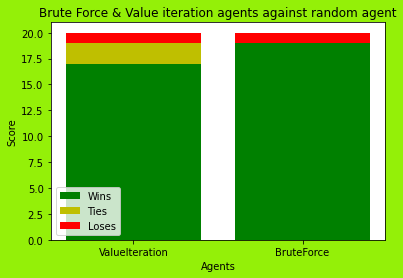

In [10]:
players_to_meassure = [FourInARowValueIterationAgent,FourInARowBruteForceAgent] 
opponent = FourInARowRandomAgent
red_player = Players.RED
yellow_player = Players.YELLOW

creator.plot_acc(players_to_meassure, "Brute Force & Value iteration agents against random agent",opponent,red_player)


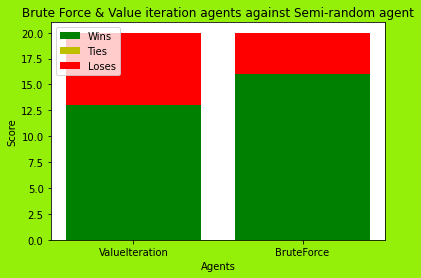

In [8]:

players_to_meassure = [FourInARowValueIterationAgent,FourInARowBruteForceAgent] 
opponent = FourInARowSemiRandomAgent
creator.plot_acc(players_to_meassure, "Brute Force & Value iteration agents against Semi-random agent",opponent,red_player)


#### 4.5.3 Accuracy: random agents - random agents
The random agents preform as well as expexted against other random agents.

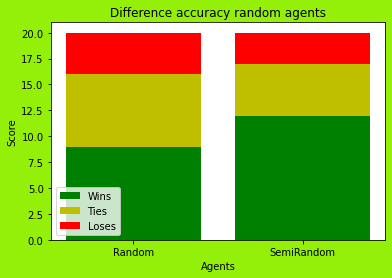

In [7]:
players_to_meassure = [FourInARowRandomAgent,FourInARowSemiRandomAgent] 
opponent = FourInARowRandomAgent

creator.plot_acc(players_to_meassure, "Difference accuracy random agents",opponent,red_player)

#### 4.5.4 Overall

The brute-force and value iteration agents preform better than random agents against other random agents.

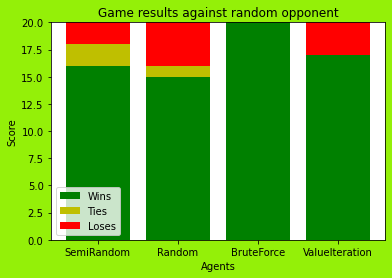

In [25]:
players_to_meassure = [FourInARowSemiRandomAgent,FourInARowRandomAgent, FourInARowBruteForceAgent,FourInARowValueIterationAgent] 
opponent = FourInARowRandomAgent
red_agent = Players.RED
creator.plot_acc(players_to_meassure, "Game results against random opponent",opponent,red_agent)

#### 4.5.5 Influence - start player
Preformance increases when agents play the first turn.

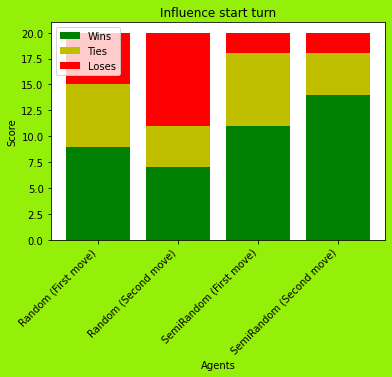

In [6]:
players_to_meassure = [FourInARowRandomAgent,FourInARowSemiRandomAgent] 
opponent = FourInARowRandomAgent
creator.plot_acc_two(players_to_meassure, "Influence start turn",opponent)

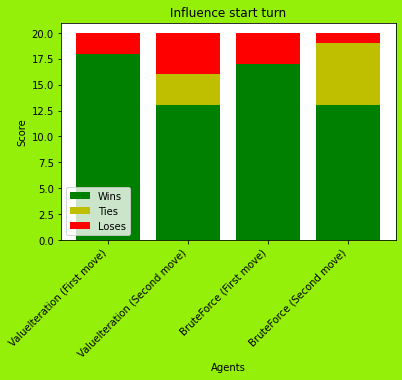

In [7]:
players_to_meassure = [FourInARowValueIterationAgent,FourInARowBruteForceAgent] 
opponent = FourInARowRandomAgent
creator.plot_acc_two(players_to_meassure, "Influence start turn",opponent)

#### 4.5.6 Execution-time agents

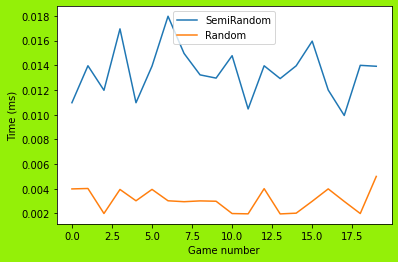

In [5]:
players_to_meassure = [FourInARowSemiRandomAgent,FourInARowRandomAgent] 
creator.plot_preformance(players_to_meassure)

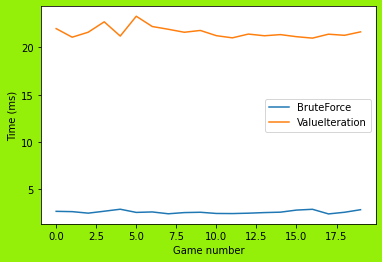

In [4]:
players_to_meassure = [ FourInARowBruteForceAgent,FourInARowValueIterationAgent] 
creator.plot_preformance(players_to_meassure)